# X-Ray Lung Classifier

Importing Libraries and loading images

In [15]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm
from IPython.display import display, Markdown

In [16]:
#Data Path
data_path = "E:/Projects/Lungs_Disease_Diagnosis/Data"

# Exploring the Images and transforming the Images

In [17]:
# defining the class name
class_name = ['NORMAL','PNEUMONIA']

# Creating a function to get the list of files
def get_list_of_files(dir_name):
   '''input - The input directory location
       output - Returns the list the files in the directory
       '''
    
   files_list = os.listdir(dir_name)
   return files_list

files_list_normal_train = get_list_of_files(data_path+'/train/'+class_name[0])
files_list_pneumonia_train = get_list_of_files(data_path+'/train/'+class_name[1])
files_list_normal_test = get_list_of_files(data_path+'/test/'+class_name[0])
files_list_pneumonia_test = get_list_of_files(data_path+'/test/'+class_name[1])

In [18]:
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneumonia_train)))
print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneumonia_test)))

Number of train samples in Normal category 1266
Number of train samples in Pneumonia category 3418
Number of test samples in Normal category 317
Number of test samples in Pneumonia category 855


# Exploring the images

(1255, 1484, 3)


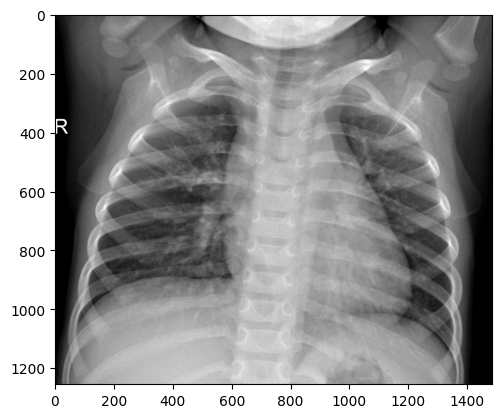

In [19]:
rand_img_no = np.random.randint(0,len(files_list_normal_train))
img = data_path + '/train/NORMAL/' + files_list_normal_train[rand_img_no]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(656, 1224, 3)


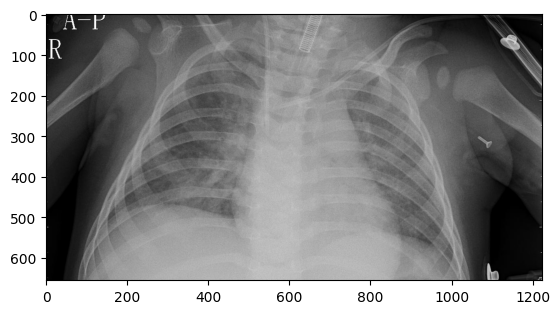

In [20]:
img = data_path + '/train/PNEUMONIA/' + files_list_pneumonia_train[np.random.randint(0,len(files_list_pneumonia_train))]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

# Insights

- If we run the above cell multiple times we can see that the images are of different shapes for the 'NORAML' and 'PNEUMONIA' images in the train folder.

(1518, 1919, 3)


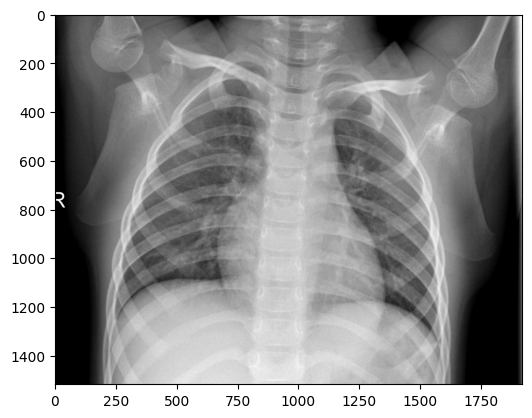

In [21]:
rand_img_no = np.random.randint(0,len(files_list_normal_test))
img = data_path + '/test/NORMAL/' + files_list_normal_test[rand_img_no]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(640, 800, 3)


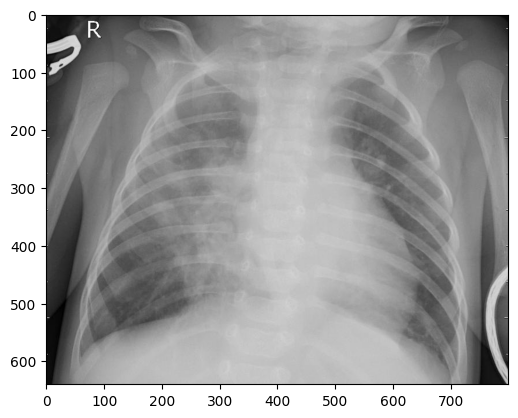

In [22]:
img = data_path + '/test/PNEUMONIA/' + files_list_pneumonia_test[np.random.randint(0,len(files_list_pneumonia_test))]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

# Transforming the Images

Now that we have previewed some sample images, the next step is to transform the dataset.
These transformations are applied to both training and testing images.

For training data, we also apply data augmentation.
Data augmentation artificially creates new variations of existing images, which helps the model generalize better and reduces overfitting.

## Transformations Applied

#### 1. Resize

Resizes the input image to a fixed size.
Ensures all images are uniform before feeding them into the model.

#### 2. CenterCrop

Crops the image from the center to a given size.
Useful for removing unwanted edges and focusing on the region of interest.

#### 3. ColorJitter

Randomly changes brightness, contrast, saturation, and hue.
Makes the model more robust to lighting conditions.

#### 4. RandomHorizontalFlip

Flips the image horizontally with a certain probability (e.g., 50%).
Helps the model handle mirrored versions of images.

#### 5. RandomRotation

Rotates the image by a random angle.
Improves robustness to orientation variations.

#### 6. ToTensor

Converts the image from a NumPy array (H × W × C) to a PyTorch tensor (C × H × W).
Also scales pixel values from \[0, 255] to \[0, 1].

#### 7. Normalize

Standardizes the tensor using a given mean and standard deviation.
Helps the model converge faster during training.

#### Summary

* Training data: Uses all transformations, including augmentation (ColorJitter, flips, rotations).
* Testing data: Uses only basic transformations (resize, crop, tensor, normalize).



In [23]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Creating Data Loaders in PyTorch

For our use case, we will use the default DataLoader from PyTorch.
We will create two data loaders:

- Training DataLoader → with shuffling enabled.

- Test DataLoader → with shuffling disabled.

# Key Parameters

- batch_size →

    - A hyperparameter that controls how many samples are processed in one forward/backward pass.

    - Can be tuned based on system configuration (GPU/CPU memory).

- shuffle →

    - True for training data → ensures randomness and prevents overfitting.

    - False for test data → ensures consistent evaluation.

- pin_memory →

    - Used when working with GPUs.

    - Helps transfer data faster from CPU to GPU by using page-locked memory.

In [24]:
train_data =  datasets.ImageFolder(os.path.join(data_path, 'train'), train_transform)
test_data =  datasets.ImageFolder(os.path.join(data_path, 'test'), test_transform)

train_loader = DataLoader(train_data, batch_size = 2, shuffle = True, pin_memory =True)
test_loader = DataLoader(test_data, batch_size = 2, shuffle = False, pin_memory =True)

class_names = train_data.classes
print(class_name)
print(f'Number of Train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')


['NORMAL', 'PNEUMONIA']
Number of Train images: 4684
Number of test images: 1172


#  Creating the model Architecture

### Input Layer
- **Input channels:** 3 (RGB image)  
- **Output channels:** configurable  
- **Kernel size:** 3 × 3  
- **Padding:** 0  
- **Bias:** True  
- **Activation:** ReLU  
- **Batch Normalization:** Applied  

### Feature Extraction
- **Max Pooling:** Used to downsample feature maps and retain important spatial features.  
- **Convolutional Layers:** The model consists of **9 convolutional layers**, each followed by:
  - ReLU activation  
  - Batch Normalization  
  - Max Pooling (at selected stages)  

### Output Layer
- **Final layer:** Fully connected / linear layer  
- **Task:** Binary classification → `Normal` vs. `Pneumonia`  

 


In [25]:
class Net(nn.Module):
    def __init__(self):
        """
        Creating custom CNN architecture for Image Classification
        """

        super(Net, self).__init__()

        # Input Block
        self.convolution_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3),
                      padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )

        self.pooling11 = nn.MaxPool2d(2,2)

        #CONVOLUTION BLOCK 1
        self.convolution_block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=20, kernel_size=(3,3),
                      padding=0, bias=True),
            
            nn.ReLU(),
            nn.BatchNorm2d(20)
        )
        self.pooling22 = nn.MaxPool2d(2,2)

        self.convolution_block3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1,1), padding=0,bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.pooling33 = nn.MaxPool2d(2, 2)

        #CONVOLUTION BLOCK 2
        self.convolution_block4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3,3), padding=0, bias = True),
            nn.ReLU(),
            nn.BatchNorm2d(20)
        )

        self.convolution_block5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(1,1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
               
        self.convolution_block6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3,3), padding=0,bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convolution_block7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1,1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )

        self.convolution_block8= nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3,3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        )

        self.convolution_block9 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3,3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )

        #OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convolution_block_out = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4,4), padding=0,bias=True),            
        )

    def forward(self, x):
        x = self.convolution_block1(x)
        x = self.pooling11(x)
        x = self.convolution_block2(x)
        x = self.pooling22(x)
        x = self.convolution_block3(x)
        x = self.pooling33(x)
        x = self.convolution_block4(x)
        x = self.convolution_block5(x)
        x = self.convolution_block6(x)
        x = self.convolution_block7(x)
        x = self.convolution_block8(x)
        x = self.convolution_block9(x)
        x = self.gap(x)
        x = self.convolution_block_out(x)
        x = x.view(-1,2)
        return F.sigmoid(x)       

In [26]:
# TO check weather cuda is available in the system or not 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
# To check the model summary
summary(model, input_size=(3, 224, 224))

Available processor cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
              ReLU-2          [-1, 8, 222, 222]               0
       BatchNorm2d-3          [-1, 8, 222, 222]              16
         MaxPool2d-4          [-1, 8, 111, 111]               0
            Conv2d-5         [-1, 20, 109, 109]           1,460
              ReLU-6         [-1, 20, 109, 109]               0
       BatchNorm2d-7         [-1, 20, 109, 109]              40
         MaxPool2d-8           [-1, 20, 54, 54]               0
            Conv2d-9           [-1, 10, 54, 54]             210
             ReLU-10           [-1, 10, 54, 54]               0
      BatchNorm2d-11           [-1, 10, 54, 54]              20
        MaxPool2d-12           [-1, 10, 27, 27]               0
           Conv2d-13           [-1, 20, 25, 25]           1,820
             Re

# Training the Data

In [27]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    """
    Description: To train model
    input: model, device, train_loader, optimizer, epoch
    output: loss, batch id and accuracy
    """
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get data
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        y_pred = model(data)

        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        loss.backward()
        optimizer.step()

        # get the index of the log probability corresponding
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    """
    Description: To test the model
    input: model, device, test_loader
    output: average loss and accuracy
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /=len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avearage loss: {:.4f}, Accuracy:{}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [28]:
# Defining the params
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 4

# Training the model
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


Loss=-0.9997371435165405 Batch_id=2341 Accuracy=72.67: 100%|██████████| 2342/2342 [08:35<00:00,  4.54it/s] 


current Learning Rate:  0.01

Test set: Avearage loss: -0.9972, Accuracy:822/1172 (70.14%)

EPOCH: 1


Loss=-0.9999983906745911 Batch_id=2341 Accuracy=72.91: 100%|██████████| 2342/2342 [08:49<00:00,  4.43it/s]


current Learning Rate:  0.01

Test set: Avearage loss: -0.9995, Accuracy:851/1172 (72.61%)

EPOCH: 2


Loss=-0.9999812245368958 Batch_id=2341 Accuracy=72.95: 100%|██████████| 2342/2342 [08:17<00:00,  4.71it/s]


current Learning Rate:  0.01

Test set: Avearage loss: -0.9993, Accuracy:845/1172 (72.10%)

EPOCH: 3


Loss=-0.999998927116394 Batch_id=2341 Accuracy=72.97: 100%|██████████| 2342/2342 [06:30<00:00,  6.00it/s] 


current Learning Rate:  0.01

Test set: Avearage loss: -0.9992, Accuracy:851/1172 (72.61%)



In [29]:
# # Defining the params
# model = Net().to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
# EPOCHS = 10

# # Training the model
# for epoch in range(EPOCHS):
#     print("EPOCH:", epoch)
#     train(model, device, train_loader, optimizer, epoch)
#     scheduler.step()
#     print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
#     test(model, device, test_loader)

In [30]:
print("Train classes:", train_data.classes)
print("Test classes:", test_data.classes)


Train classes: ['NORMAL', 'PNEUMONIA']
Test classes: ['NORMAL', 'PNEUMONIA']


# Evaluate the model

Text(0.5, 1.0, 'Test Accuracy')

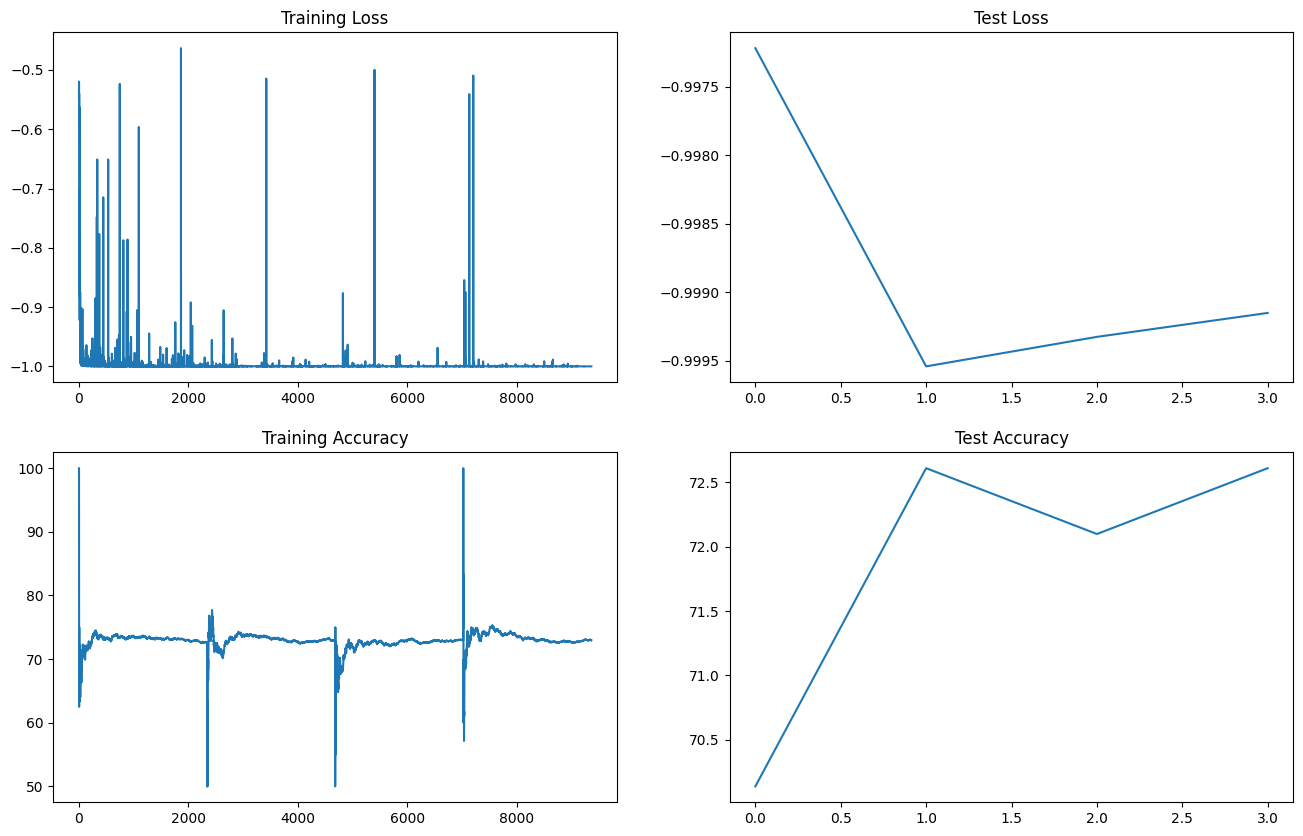

In [31]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")


#### Insights:

- **Training Loss**: Starts with big spikes (around -0.5 to -1.0), then stabilizes near -1.0, showing a bumpy but settling learning process.
- **Training Accuracy**: Hovers around 60-80%, with drops to 0%, suggesting occasional confusion.
- **Test Loss**: Drops from -0.9825 to -0.9975, then slightly up, indicating improving but not perfect predictions.
- **Test Accuracy**: Starts at 80%, dips to 74%, then rises to 76-78%, showing decent but wobbly improvement.

In [32]:
torch.save(model.state_dict(), "xray_model.pth")